# HW3 - Lorenzo Mazzocco

In [50]:
import openmc
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy
import sys
from tabulate import tabulate

.

# QUESTION 1

In the following Monte Carlo code a combination of cartesian coordinates $[u,v,w]$ and polar coordinates according to the ISO convention $[r, \theta, \varphi]$. The direction of flight is always stored as cartesian coordinates but is derived using sampling from the spherical variables space and then converted to cartesian using Cashwell rotation formulas.

## a)

For this question H-1 is considered non-absorbing ($\sigma_t = \sigma_s$). Real elastic scattering cross sections are sampled from the ENDF8 library at every collision.

In [59]:
# LOAD XS FOR H1

filepath = '/Users/lorenzomazzocco/openmc/endfb80_hdf5/H1.h5'
H1_ace = openmc.data.IncidentNeutron.from_hdf5(filepath)
es = H1_ace[2] #2 is elastic scattering
energies = H1_ace.energy['294K']  #energies contains the grid points on which the cross-sections are stored
xs_es = es.xs['294K'](energies)*1e-24 # cm2
xs_energies = energies

In [60]:
def simulation(A, N, nps, xs_data, E_max=1e6, E_min=0.1):
    
    E_histories = []
    position_histories = []

    for i in range(nps):
        # Initialize energy, position and direction
        E = E_max
        position = np.array([0,0,0])
        r = 1
        theta = np.random.uniform(0, np.pi)
        phi = np.random.uniform(0, 2*np.pi)
        direction = np.array([r*np.sin(theta)*np.cos(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)]) # cartesian 

        E_history = []
        position_history = []

        while E > E_min:

            E_history.append(E)
            position_history.append(position)

            # Sample travel distance from exponential distribution (numpy built in sampling)
            xs = np.interp(E, xs_data[0], xs_data[1]) # linear interpolation to get xs for our specific energy
            XS_es = N*xs
            distance = np.random.exponential(1/XS_es)

            # Get new position
            position_new = position + direction*distance

            # COLLISION
            # Sample scattering angle in COM, get final energy and lab angle
            mu_CM = np.random.uniform(-1, 1)
            E_new = E*(A**2 + 2*mu_CM*A + 1)/(A**2 + 2*A + 1)
            mu_LAB = (1+A*mu_CM)/np.sqrt(A**2 + 2*mu_CM*A + 1)

            # Get new direction
            phi = np.random.uniform(0, 2*np.pi)

            u = direction[0]
            v = direction[1]
            w = direction[2]

            u_new = mu_LAB*u + (np.sqrt(1-mu_LAB**2)*(u*w*np.cos(phi) - v*np.sin(phi)))/np.sqrt(1-w**2)
            v_new = mu_LAB*v + (np.sqrt(1-mu_LAB**2)*(v*w*np.cos(phi) + u*np.sin(phi)))/np.sqrt(1-w**2)
            w_new = mu_LAB*w - np.sqrt(1-mu_LAB**2)*np.sqrt(1-w**2)*np.cos(phi)

            direction_new = np.array([u_new, v_new, w_new])

            # Update energy, position and direction  
            E = E_new
            position = position_new
            direction = direction_new

        E_histories.append(E_history)
        position_histories.append(position_history)
        
    return E_histories, position_histories

In [7]:
rhos = np.linspace(0.7, 1.0, 5)

crow_flights_mean = []
crow_flights_std = []

for rho in rhos:
    A=1
    avo = 6.022e23
    N = rho*avo/A # 1/cm3

    H1_EE, H1_pp = simulation(A, N, nps=2000, xs_data=[xs_energies, xs_es])
    
    crow_flights_raw = []

    for positions in H1_pp:
        crow_flight = np.sqrt(np.sum(np.square(np.subtract(positions[-1],positions[0]))))
        crow_flights_raw.append(crow_flight)
    
    crow_flights_mean.append(np.mean(crow_flights_raw))
    crow_flights_std.append(np.std(crow_flights_raw))
    

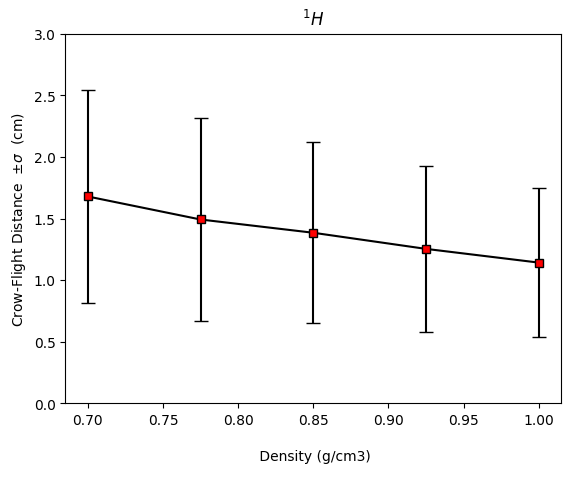

In [8]:
plt.errorbar(rhos, crow_flights_mean, yerr=crow_flights_std, color='k', marker='s', capsize=5, mfc='red', mec='k', ms=6, mew=1)
plt.xlabel('\n Density (g/cm3)\n')
plt.ylabel(r"Crow-Flight Distance  $\pm \sigma$  (cm)")
plt.title(r"$^{1}H$")
plt.ylim(0,3)
plt.show()

.

.

## b)

In this question the concentration of boron varies from 0 ppm to 1000 ppm. Even though even for the highest possible B concentration (0.1%) we can model the system as infinitely diluted I would like to code a proper simulation. Therefore this simulation considers both scattering and absorption for H1 and B, with boron taken at natural isotopic abundance. 

So if x is the B concentration in ppm, the isotopic inventory is:

- H-1:     $1-x\cdot10^{-6}$ 

- B-10:   $0.2\cdot x\cdot 10^{-6}$

- B-11:   $0.8\cdot x\cdot 10^{-6}$


For the sake of simplicity for each isotope the total and elastic scattering xs are loaded and the absorption xs is defined as: $\sigma_a = \sigma_t - \sigma_s$

In [13]:
# LOAD XS DATA
# H1
filepath = '/Users/lorenzomazzocco/openmc/endfb80_hdf5/H1.h5'
H1_ace = openmc.data.IncidentNeutron.from_hdf5(filepath)
es = H1_ace[2] #2 is elastic scattering
H1_energies = H1_ace.energy['294K']  #energies contains the grid points on which the cross-sections are stored
xs_H1_es = es.xs['294K'](H1_energies)*1e-24 # cm2

tot = H1_ace[1] #1 is total
xs_H1_tot = tot.xs['294K'](H1_energies)*1e-24 #cm2
xs_H1_abs = np.subtract(xs_H1_tot, xs_H1_es)
xs_H1_energies = H1_energies

# B10
filepath = '/Users/lorenzomazzocco/openmc/endfb80_hdf5/B10.h5'
B10_ace = openmc.data.IncidentNeutron.from_hdf5(filepath)
es = B10_ace[2] #2 is elastic scattering
B10_energies = B10_ace.energy['294K']  #energies contains the grid points on which the cross-sections are stored
xs_B10_es = es.xs['294K'](B10_energies)*1e-24 # cm2

tot = B10_ace[1] #1 is total
xs_B10_tot = tot.xs['294K'](B10_energies)*1e-24 #cm2
xs_B10_abs = np.subtract(xs_B10_tot, xs_B10_es)
xs_B10_energies = B10_energies

# B11
filepath = '/Users/lorenzomazzocco/openmc/endfb80_hdf5/B11.h5'
B11_ace = openmc.data.IncidentNeutron.from_hdf5(filepath)
es = B11_ace[2] #2 is elastic scattering
B11_energies = B11_ace.energy['294K']  #energies contains the grid points on which the cross-sections are stored
xs_B11_es = es.xs['294K'](B11_energies)*1e-24 # cm2

tot = B11_ace[1] #1 is total
xs_B11_tot = tot.xs['294K'](B11_energies)*1e-24 #cm2
xs_B11_abs = np.subtract(xs_B11_tot, xs_B11_es)
xs_B11_energies = B11_energies

xs_data = [[xs_H1_energies, xs_H1_tot, xs_H1_es, xs_H1_abs],[xs_B10_energies, xs_B10_tot, xs_B10_es, xs_B10_abs],[xs_B11_energies, xs_B11_tot, xs_B11_es, xs_B11_abs]]

In [14]:
# REDEFINE SIMULATION FUNCTION

def simulation(AA, N, boron_ppm, nps, xs_data, E_max=1e6, E_min=0.1):
    
    E_histories = []
    position_histories = []

    for i in range(nps):
        #np.random.seed(2)
        if i%10 == 0:
            string = "="*int(30*i/(nps-1))
            sys.stdout.write("\r x = {:.0f} ppm    [{:<29}]".format(boron_ppm,string))
            sys.stdout.flush()
        
        # Initialize energy, position and direction
        E = E_max
        position = np.array([0,0,0])
        r = 1
        theta = np.random.uniform(0, np.pi)
        phi = np.random.uniform(0, 2*np.pi)
        direction = np.array([r*np.sin(theta)*np.cos(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)]) # cartesian 

        E_history = [E]
        position_history = [position]

        while E > E_min:

            # Sample travel distance from exponential distribution (numpy built in sampling)
            x = boron_ppm
            N_medium = (1-x*1e-6)*N
            N_B10 = (0.2*x*1e-6)*N
            N_B11 = (0.8*x*1e-6)*N
            NN = [N_medium, N_B10, N_B11]
            
            xs_tot_medium = np.interp(E, xs_data[0][0], xs_data[0][1])
            xs_tot_B10 = np.interp(E, xs_data[1][0], xs_data[1][1])
            xs_tot_B11 = np.interp(E, xs_data[2][0], xs_data[2][1])
            xxss_tot = [xs_tot_medium, xs_tot_B10, xs_tot_B11]
            
            XXSS_tot = np.multiply(NN, xxss_tot)
            
            XS_tot = np.dot(NN, xxss_tot)
            distance = np.random.exponential(1/XS_tot)

            # Get new position
            position_new = position + direction*distance

            # COLLISION
            
            # Sample collision isotope 
            collision_isotope_bins = np.cumsum(XXSS_tot)/np.sum(XXSS_tot)
            collision_isotope_idx = np.digitize(x=np.random.uniform(0,1), bins=collision_isotope_bins)

            
            # Sample collision reaction (idx=0 scattering, idx=1 absorption, if absorption kill particle)
            xs_es = np.interp(E, xs_data[collision_isotope_idx][0], xs_data[collision_isotope_idx][2])
            xs_abs = np.interp(E, xs_data[collision_isotope_idx][0], xs_data[collision_isotope_idx][3])
            
            xxss = [xs_es, xs_abs]
            collision_reaction_bins = np.cumsum(xxss)/np.sum(xxss)
            collision_reaction_idx = np.digitize(x=np.random.uniform(0,1), bins=collision_reaction_bins)
            
            if collision_reaction_idx:
                # Update position  
                position = position_new

                E_history.append(E)
                position_history.append(position)
                break
            
            # Sample scattering angle in COM, get final energy and lab angle
            A = AA[collision_isotope_idx]
            mu_CM = np.random.uniform(-1, 1)
            E_new = E*(A**2 + 2*mu_CM*A + 1)/(A**2 + 2*A + 1)
            mu_LAB = (1+A*mu_CM)/np.sqrt(A**2 + 2*mu_CM*A + 1)

            # Get new direction
            phi = np.random.uniform(0, 2*np.pi)

            u = direction[0]
            v = direction[1]
            w = direction[2]

            u_new = mu_LAB*u + (np.sqrt(1-mu_LAB**2)*(u*w*np.cos(phi) - v*np.sin(phi)))/np.sqrt(1-w**2)
            v_new = mu_LAB*v + (np.sqrt(1-mu_LAB**2)*(v*w*np.cos(phi) + u*np.sin(phi)))/np.sqrt(1-w**2)
            w_new = mu_LAB*w - np.sqrt(1-mu_LAB**2)*np.sqrt(1-w**2)*np.cos(phi)

            direction_new = np.array([u_new, v_new, w_new])

            # Update energy, position and direction  
            E = E_new
            position = position_new
            direction = direction_new
            
            E_history.append(E)
            position_history.append(position)

        E_histories.append(E_history)
        position_histories.append(position_history)
        
    sys.stdout.flush()
    return E_histories, position_histories

In [15]:
# LOAD XS DATA
# H1
filepath = '/Users/lorenzomazzocco/openmc/endfb80_hdf5/H1.h5'
H1_ace = openmc.data.IncidentNeutron.from_hdf5(filepath)
es = H1_ace[2] #2 is elastic scattering
H1_energies = H1_ace.energy['294K']  #energies contains the grid points on which the cross-sections are stored
xs_H1_es = es.xs['294K'](H1_energies)*1e-24 # cm2

tot = H1_ace[1] #1 is total
xs_H1_tot = tot.xs['294K'](H1_energies)*1e-24 #cm2
xs_H1_abs = np.subtract(xs_H1_tot, xs_H1_es)
xs_H1_energies = H1_energies

# B10
filepath = '/Users/lorenzomazzocco/openmc/endfb80_hdf5/B10.h5'
B10_ace = openmc.data.IncidentNeutron.from_hdf5(filepath)
es = B10_ace[2] #2 is elastic scattering
B10_energies = B10_ace.energy['294K']  #energies contains the grid points on which the cross-sections are stored
xs_B10_es = es.xs['294K'](B10_energies)*1e-24 # cm2

tot = B10_ace[1] #1 is total
xs_B10_tot = tot.xs['294K'](B10_energies)*1e-24 #cm2
xs_B10_abs = np.subtract(xs_B10_tot, xs_B10_es)
xs_B10_energies = B10_energies

# B11
filepath = '/Users/lorenzomazzocco/openmc/endfb80_hdf5/B11.h5'
B11_ace = openmc.data.IncidentNeutron.from_hdf5(filepath)
es = B11_ace[2] #2 is elastic scattering
B11_energies = B11_ace.energy['294K']  #energies contains the grid points on which the cross-sections are stored
xs_B11_es = es.xs['294K'](B11_energies)*1e-24 # cm2

tot = B11_ace[1] #1 is total
xs_B11_tot = tot.xs['294K'](B11_energies)*1e-24 #cm2
xs_B11_abs = np.subtract(xs_B11_tot, xs_B11_es)
xs_B11_energies = B11_energies

xs_data = [[xs_H1_energies, xs_H1_tot, xs_H1_es, xs_H1_abs],[xs_B10_energies, xs_B10_tot, xs_B10_es, xs_B10_abs],[xs_B11_energies, xs_B11_tot, xs_B11_es, xs_B11_abs]]

The density for H1 is $\rho_{H1} = 0.7 g/cm3$.
Therefore the atomic density for such isotope is $N_{H1} = \frac{\rho_{H1} \cdot N_{avo}}{MM_{H1}} = 4.2154\cdot 10^{23} cm^{-3}$.

Then I can compute the atomic densities of the boron isotopes ($x$ is B concentration in ppm):
- $N_{B10} = 0.2\cdot x\cdot10^{-6}\cdot N_{mix}$
- $N_{B11} = 0.8\cdot x\cdot10^{-6}\cdot N_{mix}$

Knowing that: $N_{mix} = N_{H1} + N_{B10} + N_{B11}$, solving for $N_{mix}$ one gets:

$$N_{mix} = \frac{N_{H1}}{1-x\cdot 10^{-6}}$$

Please note that this approach is valid only for $x << 10^6 $ because we are fixing the density of H1. If the boron concentration where to become predominant the mixture density would diverge to infinity.

In [16]:
# Compute mixture atomic density
xx = np.linspace(0, 1000, 5)

crow_flights_mean = []
crow_flights_std = []

for x in xx:
    N_H1 = 4.2154*1e23
    N_mix = N_H1/(1-x*1e-6)

    H1_EE, H1_pp = simulation([1,10,11], N=N_mix, boron_ppm=x, nps=5000, xs_data=xs_data)

    crow_flights_raw = []

    for positions in H1_pp:
        crow_flight = np.sqrt(np.sum(np.square(np.subtract(positions[-1],positions[0]))))
        crow_flights_raw.append(crow_flight)
    
    crow_flights_mean.append(np.mean(crow_flights_raw))
    crow_flights_std.append(np.std(crow_flights_raw))
    
    


 x = 1000 ppm    [=============================]

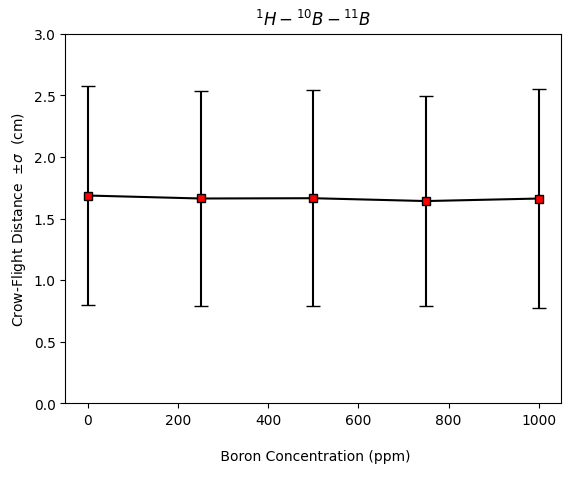

In [17]:
plt.errorbar(xx, crow_flights_mean, yerr=crow_flights_std, color='k', marker='s', capsize=5, mfc='red', mec='k', ms=6, mew=1)
plt.xlabel('\n Boron Concentration (ppm)\n')
plt.ylabel(r"Crow-Flight Distance  $\pm \sigma$  (cm)")
plt.title(r"$^{1}H - ^{10}B - ^{11}B$")
plt.ylim(0,3)
plt.show()

.

.

## c)



In [19]:
# LOAD XS DATA
# C12
filepath = '/Users/lorenzomazzocco/openmc/endfb80_hdf5/C12.h5'
C12_ace = openmc.data.IncidentNeutron.from_hdf5(filepath)
es = C12_ace[2] #2 is elastic scattering
C12_energies = C12_ace.energy['294K']  #energies contains the grid points on which the cross-sections are stored
xs_C12_es = es.xs['294K'](C12_energies)*1e-24 # cm2

tot = C12_ace[1] #1 is total
xs_C12_tot = tot.xs['294K'](C12_energies)*1e-24 #cm2
xs_C12_abs = np.subtract(xs_C12_tot, xs_C12_es)
xs_C12_energies = C12_energies

# B10
filepath = '/Users/lorenzomazzocco/openmc/endfb80_hdf5/B10.h5'
B10_ace = openmc.data.IncidentNeutron.from_hdf5(filepath)
es = B10_ace[2] #2 is elastic scattering
B10_energies = B10_ace.energy['294K']  #energies contains the grid points on which the cross-sections are stored
xs_B10_es = es.xs['294K'](B10_energies)*1e-24 # cm2

tot = B10_ace[1] #1 is total
xs_B10_tot = tot.xs['294K'](B10_energies)*1e-24 #cm2
xs_B10_abs = np.subtract(xs_B10_tot, xs_B10_es)
xs_B10_energies = B10_energies

# B11
filepath = '/Users/lorenzomazzocco/openmc/endfb80_hdf5/B11.h5'
B11_ace = openmc.data.IncidentNeutron.from_hdf5(filepath)
es = B11_ace[2] #2 is elastic scattering
B11_energies = B11_ace.energy['294K']  #energies contains the grid points on which the cross-sections are stored
xs_B11_es = es.xs['294K'](B11_energies)*1e-24 # cm2

tot = B11_ace[1] #1 is total
xs_B11_tot = tot.xs['294K'](B11_energies)*1e-24 #cm2
xs_B11_abs = np.subtract(xs_B11_tot, xs_B11_es)
xs_B11_energies = B11_energies

xs_data = [[xs_C12_energies, xs_C12_tot, xs_C12_es, xs_C12_abs],[xs_B10_energies, xs_B10_tot, xs_B10_es, xs_B10_abs],[xs_B11_energies, xs_B11_tot, xs_B11_es, xs_B11_abs]]

In [20]:
xx = np.linspace(0,10,5)
N_mix = 1e23 

crow_flights_mean = []
crow_flights_std = []

for x in xx:
    C12_EE, C12_pp = simulation([12,10,11], N=N_mix, boron_ppm=x, nps=2000, xs_data=xs_data)

    crow_flights_raw = []

    for positions in C12_pp:
        crow_flight = np.sqrt(np.sum(np.square(np.subtract(positions[-1],positions[0]))))
        crow_flights_raw.append(crow_flight)
    
    crow_flights_mean.append(np.mean(crow_flights_raw))
    crow_flights_std.append(np.std(crow_flights_raw))

 x = 10 ppm    [=============================]

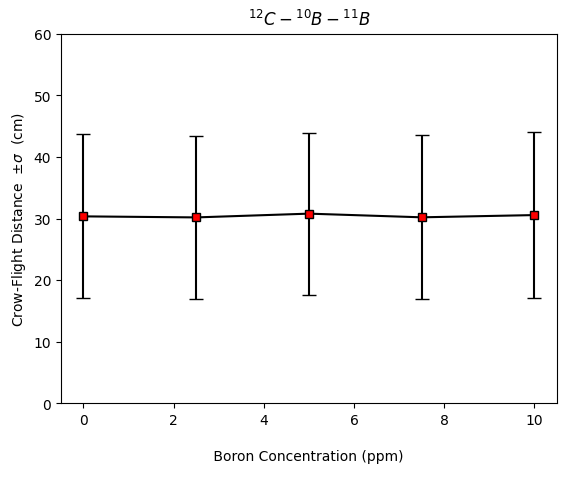

In [21]:
plt.errorbar(xx, crow_flights_mean, yerr=crow_flights_std, color='k', marker='s', capsize=5, mfc='red', mec='k', ms=6, mew=1)
plt.xlabel('\n Boron Concentration (ppm) \n')
plt.ylabel(r"Crow-Flight Distance  $\pm \sigma$  (cm)")
plt.title(r"$^{12}C - ^{10}B - ^{11}B$")
plt.ylim(0,60)
plt.show()

We can see that crow-flight distance is independent of the boron concentration. This is because this metric is a function of the fast parameters (the majority of the distance is covered during the very first flights, when the neutron is still fast). At the same time boron is a thermal absorber.

.

.

# QUESTION 2

## a-b)

The definition of effective resonance integral is:
$$ RI_{eff} = \int_{E_g}^{E_{g-1}} \sigma(E)\phi(E) dE$$

which is just the reaction rate inside group $g$ divided by the nuclide density $N$ of the target nuclide.

The group XS then is just:

$$ \sigma_g = \frac{RI_{eff}}{\int_{E_g}^{E_{g-1}} \phi(E) dE} $$

We can program a Monte Carlo slowing down code tallying both the reaction rate of interest and the flux to then compute those two quantities.
This approach is valid but inconvinient for highly diluted systems since capture reactions in the groups by the resonant absorber are going to be extremely rare. A better way to do this is to estimate the flux using a fine energy discretization and integrate the flux and xs afterwards using the definition of RI.


In [158]:
def compute_MGXS(nuclide_0, nuclide_1_xs_pot, AA, groups, dilution, T, xs_folder, nps, E_max=1e5, E_min=1, N0=1):
    np.random.seed(2)
    
    N1 = N0*dilution
     
    fine_energy_groups = np.linspace(groups[0], groups[-1], 1000000)
    flux_counter = np.zeros(len(fine_energy_groups)-1)
    
    # RETRIEVE CONTINUOUS ENERGY XS
    # Nuclide 0 (resonant absorber)
    filepath = '/Users/lorenzomazzocco/openmc/{}/{}.h5'.format(xs_folder, nuclide_0)
    nuclide0_ace = openmc.data.IncidentNeutron.from_hdf5(filepath)
    nuclide0_scat = nuclide0_ace[2]
    nuclide0_abso = nuclide0_ace[102]
    
    xs_data = [nuclide0_scat, nuclide0_abso] #first index is nuclide, second index is reaction
    
    for i in range(nps):
        if i%10 == 0:
            string = "="*int(30*i/(nps-1))
            sys.stdout.write("\r [{:<29}]".format(string))
            sys.stdout.flush()
            
        # Initialize energy
        E = E_max

        while E > E_min:

            # Select which nuclide we are colliding with
            NN = [N0, N1]
            xxss_tot = [(xs_data[0].xs[T](E) + xs_data[1].xs[T](E)), nuclide_1_xs_pot] # only scattering for moderator
            XXSS_tot = np.multiply(NN, xxss_tot)

            collision_isotope_bins = np.cumsum(XXSS_tot)/np.sum(XXSS_tot)
            collision_isotope_idx = np.digitize(x=np.random.uniform(0,1), bins=collision_isotope_bins)

            # Select reaction 
            if not collision_isotope_idx: # if I collide with resonant absorber then select reaction type
                xxss = [xs_data[0].xs[T](E), xs_data[1].xs[T](E)]  

                collision_reaction_bins = np.cumsum(xxss)/np.sum(xxss)
                collision_reaction_idx = np.digitize(x=np.random.uniform(0,1), bins=collision_reaction_bins)

                if collision_reaction_idx: # if reaction is absorption kill particle   
                    break
                
            

            # Sample scattering angle in COM, get final energy and lab angle
            A = AA[collision_isotope_idx]
            mu_CM = np.random.uniform(-1, 1)
            E_new = E*(A**2 + 2*mu_CM*A + 1)/(A**2 + 2*A + 1)

            # Count flux
            if (groups[0] <= E <= groups[-1]): #only count absorption if energy is in groups range
                idx = np.digitize(E, fine_energy_groups)-1
                flux_counter[idx] += 1/np.sum(XXSS_tot)/nps

            # Update energy
            E = E_new


    flux_counter = flux_counter/np.sum(flux_counter)
            
    # COMPUTE RESONANCE INTEGRAL
    
    RIs = [] #Resonance Integrals for each group
    FIs = [] #Flux Integrals for each group
    
    # Prepare functions and domains for integration
    energies = fine_energy_groups[:-1]
    de = energies[1]-energies[0]
       
    RI_integrand = np.multiply(nuclide0_abso.xs[T](energies), flux_counter)
    RI_integrands = []
    flux_integrands = []
    
    for i in range(len(groups)-1):
        lower = groups[i]
        upper = groups[i+1]
        
        logic = (lower <= energies) & (energies < upper)
        
        RI_integrands.append(RI_integrand[logic == 1])
        flux_integrands.append(flux_counter[logic == 1])

    # Integrate in energy
    for i in range(len(groups)-1):
        ri_integral = scipy.integrate.simpson(RI_integrands[i], dx=de)
        flux_integral = scipy.integrate.simpson(flux_integrands[i], dx=de)
        
        RIs.append(ri_integral)
        FIs.append(flux_integral)
        
        
    # Compute MGXS
    MGXS = np.divide(RIs, FIs)
    print(MGXS)
    #print(RIs)
    
    return RIs, MGXS, FIs, flux_counter


In [159]:
ENDF7 = 'endfb-vii.1/neutron'
ENDF8 = 'endfb80_hdf5'

temperatures = ['294K', '900K']
dilutions = [10,1000,1000000]

In [160]:
RI_H1 = []
MGXS_H1 = []
FI_H1 = []

for temp in temperatures:
    for dilution in dilutions:
        RI, MGXS, FI, _ = compute_MGXS(nuclide_0='U238', nuclide_1_xs_pot=20.478, AA=[238, 1], groups=[6,10,25,50], dilution=dilution, T=temp, xs_folder=ENDF7, nps=50000)
    
        RI_H1.append(RI)
        MGXS_H1.append(MGXS)
        FI_H1.append(FI)
        
        np.savetxt('RI_H1.csv', RI_H1, delimiter=",")
        np.savetxt('MGXS_H1.csv', MGXS_H1, delimiter=",")
        np.savetxt('FI_H1.csv', FI_H1, delimiter=",")


 [=============================][12.64729819  4.40627741  5.2053224 ]
 [=============================][172.24660461  50.42781758  43.94209769]
 [=============================][250.48185993  68.15748114  61.09879369]
 [=============================][12.51940378  4.88678317  5.54633459]
 [=============================][190.46492363  56.37269336  49.29159375]
 [=============================][251.10766911  68.64720641  60.87190575]


In [161]:
RI_C12 = []
MGXS_C12 = []
FI_C12 = []

for temp in temperatures:
    for dilution in dilutions:
        RI, MGXS, FI, _ = compute_MGXS(nuclide_0='U238', nuclide_1_xs_pot=4.74, AA=[238, 12], groups=[6,10,25,50], dilution=dilution, T=temp, xs_folder=ENDF7, nps=15000)
        RI_C12.append(RI)
        MGXS_C12.append(MGXS)
        FI_C12.append(FI)
        
        np.savetxt('RI_C12.csv', RI_C12, delimiter=",")
        np.savetxt('MGXS_C12.csv', MGXS_C12, delimiter=",")
        np.savetxt('FI_C12.csv', FI_C12, delimiter=",")

 [=============================][5.48713955 2.79388838 2.98706184]
 [=============================][86.68503412 25.33225672 23.70835011]
 [=============================][252.0813232   75.19147424  57.63760916]
 [=============================][5.06256173 2.86524406 2.96182542]
 [=============================][114.34153842  32.5368272   28.07884603]
 [=============================][250.05052461  73.71827     59.07831377]


In [162]:
# PRINT H1 TABLE
RI_H1 = np.genfromtxt('RI_H1.csv', delimiter=',')
MGXS_H1 = np.genfromtxt('MGXS_H1.csv', delimiter=',')
FI_H1 = np.genfromtxt('FI_H1.csv', delimiter=',')

row_names = ['10 - 294K', '1k - 294K', '1M - 294K',  '10 - 900K',  '1k - 900K',  '1M - 900K']
header = ['Background (H1)', '6-10eV RI', '6-10eV MGXS', '10-25eV RI', '10-25eV MGXS', '25-50eV RI', '25-50eV MGXS']

norm = np.log(50/25)/FI_H1[0][-1]
rows = []
for i in range(len(row_names)):
    row = []
    row.append(row_names[i])
    row.append("{:.2f}".format(RI_H1[i][0]*norm))
    row.append("{:.2f}".format(MGXS_H1[i][0]))
    row.append("{:.2f}".format(RI_H1[i][1]*norm))
    row.append("{:.2f}".format(MGXS_H1[i][1]))
    row.append("{:.2f}".format(RI_H1[i][2]*norm))
    row.append("{:.2f}".format(MGXS_H1[i][2]))
    rows.append(row)

with open('MGXS_TABLE.txt', 'w') as f:
    f.write('U-238 diluted in H-1 | Capture Resonance Integrals and Group Cross Sections\n')
    f.write(tabulate(rows, header, tablefmt="outline"))
    f.write('\n\n\n\n\n')
       

In [163]:
# PRINT C12 TABLE
RI_C12 = np.genfromtxt('RI_C12.csv', delimiter=',')
MGXS_C12 = np.genfromtxt('MGXS_C12.csv', delimiter=',')
FI_C12 = np.genfromtxt('FI_C12.csv', delimiter=',')

row_names = ['10 - 294K', '1k - 294K', '1M - 294K',  '10 - 900K',  '1k - 900K',  '1M - 900K']
header = ['Background (C12)', '6-10eV RI', '6-10eV MGXS', '10-25eV RI', '10-25eV MGXS', '25-50eV RI', '25-50eV MGXS']

norm = np.log(50/25)/FI_C12[0][-1]
rows = []
for i in range(len(row_names)):
    row = []
    row.append(row_names[i])
    row.append("{:.2f}".format(RI_C12[i][0]*norm))
    row.append("{:.2f}".format(MGXS_C12[i][0]))
    row.append("{:.2f}".format(RI_C12[i][1]*norm))
    row.append("{:.2f}".format(MGXS_C12[i][1]))
    row.append("{:.2f}".format(RI_C12[i][2]*norm))
    row.append("{:.2f}".format(MGXS_C12[i][2]))
    rows.append(row)

with open('MGXS_TABLE.txt', 'a') as f:
    f.write('U-238 diluted in C-12 | Capture Resonance Integrals and Group Cross Sections\n')
    f.write(tabulate(rows, header, tablefmt="outline")) 

The resulting tables are attached in a .txt file. Unfortunately my results seem to be wrong so I based my analysis on theory and results from other students. 

## c)
It's evident that increasing dilution increases both the MGXS and RI, this is because with higher dilution the resonances experience less self-shielding and have therefore access to a greater neutron flux. In the infinite dilution limit the flux has a 1/E spectrum, exactly like for energies far away from the resonances.

Also increasing temperature increases both MGXS and RI and this is because of the Doppler effect. It's important to note that the increased absorption due to the lowering and widending of the resonances is not due to the change under the area of the resonance curve (which stays approximately the same) but it's due to the lower self-shielding effect that a flatter resonance experiences. In the limit of constant absorption one can verify both analytically and empirically that the overall absorption of neutrons is far far grater compared to a resonant absorption system. Luckily the main absorbers in our systems are resonant (like U238) and therefore we can build nuclear reactors with good neutron economies.

## d)
It's important to keep in mind that in this simulation we did not take into account spatial effects and that we don't consider absorption for our moderators. 

Knowing nothing about self shielding one would say that, given the scattering kernels of H1 and C12, H1 is a better moderator because it has bigger scattering kernel (so a narrow resonance model is more appropriate). And that is indeed the case in the infinite dilution limit with no self-shielding: we see that the absorption XS for U238 is higher for a C12 background than a H1 background. 

Nevertheless at lower dilution, when self-shielding comes into play, the carbon moderator seem to perform better than the hydrogen moderator (both XS and RI for U-238 absorption are lower).

In real life one can't choose a moderator based solely on this kind of analysis. Crow-flight distance, average number of collision to thermalization and, most importantly, absorption by the moderator itself are fundamental parameters when choosing a moderator.

.

.

# QUESTION 3

A way of estimating the neutron population at any given time is to use the definition of flux, which is:

$$ \phi(E) = n(E)v = n(E)\sqrt(2E/m)$$

so one can compute the neutron density by using $n = \phi/v$. Then we can just multiply the just obtained density by the core volume and obtain the overall number of particles.

I did so using a simple pincell calculation in OpenMC, tallying both the neutron flux and the heating deposition rate (for normalization). To increase precision I did so 500 energy groups and I then carried out the calculation. Next to each variable I put the unit of measurement for better context. Necessary parameters for a typical PWR are:

- Number of assemblies: 194
- Pincells per assemmblies: 17x17
- Core Height: 350 cm

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

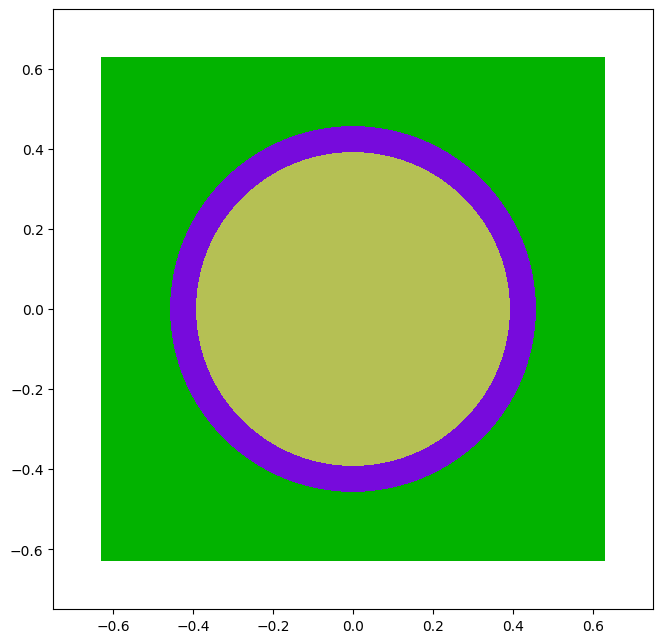

In [229]:
import os
os.environ['OPENMC_CROSS_SECTIONS'] = "/Users/lorenzomazzocco/openmc/endfb80_hdf5/cross_sections.xml"

# MATERIALS
uo2 = openmc.Material(name='fuel')
uo2.add_element('U', 1, enrichment=3.2)
uo2.add_element('O', 2)
uo2.set_density('g/cc', 10.341)

zirc = openmc.Material()
zirc.add_element('Zr', 100.0, 'wo')
zirc.set_density('g/cm3', 6.55)

water = openmc.Material()
water.add_element('H', 2.0, 'ao')
water.add_element('O', 1.0, 'ao')
water.set_density('g/cc', 1)

materials = openmc.Materials([uo2, water, zirc])
materials.export_to_xml()

# GEOMETRY
radius_fuel = 0.3922
radius_gap = 0.4001
radius_clad = 0.4572
pitch = 1.26
zmax = 10.0

rfo = openmc.ZCylinder(r=radius_fuel)
rco = openmc.ZCylinder(r=radius_clad)
xy_box = openmc.model.rectangular_prism(pitch, pitch, boundary_type='reflective')
z0 = openmc.ZPlane(z0=-zmax, boundary_type='reflective')
z1 = openmc.ZPlane(z0=zmax, boundary_type='reflective')

fuel = openmc.Cell(name='fuel', fill=uo2)
fuel.region = -rfo & +z0 & -z1
clad = openmc.Cell(name='clad', fill=zirc)
clad.region = +rfo & -rco & +z0 & -z1
mod = openmc.Cell(name='moderator', fill=water)
mod.region = +rco & xy_box & +z0 & -z1
root = openmc.Universe(cells=(fuel, clad, mod))
geometry = openmc.Geometry(root)
geometry.export_to_xml()

root.plot(origin=(0.0, 0.0, 0.0), width=(1.5, 1.5), pixels=(600, 600), basis='xy', color_by='material')


# SETTINGS
point = openmc.stats.Point((0, 0, 0))
source = openmc.Source(space=point)

settings = openmc.Settings()
settings.source = source
settings.batches = 100
settings.inactive = 10
settings.particles = 20000
settings.export_to_xml()


# TALLIES
energies = np.linspace(1e-5, 20e6, 500)
energy_filter = openmc.EnergyFilter(energies)

flux_tally = openmc.Tally(name='flux_tally')
flux_tally.filters = [energy_filter]
flux_tally.scores = ['flux']


heating_tally = openmc.Tally(name='heating_tally')
heating_tally.scores = ['heating-local']

tallies = openmc.Tallies([flux_tally, heating_tally])
tallies.export_to_xml()


openmc.run()



In [231]:
energies = np.linspace(1e-3, 1e6, 500)
energies = (energies[:-1] + energies[1:]) /2

sp = openmc.StatePoint('statepoint.100.h5', autolink=False)
t_heating = sp.get_tally(name='heating_tally')
heating = t_heating.get_values(scores=['heating-local'], value='mean') # eV/src

t_flux = sp.get_tally(name='flux_tally')
flux_spectrum = t_flux.get_values(scores=['flux'], value='mean') # n-cm/src

H = 1.602e-19 # J/eV

heating = H*heating # J/src
f = 3000e6/193/17/17/heating # src/sec

flux_spectrum = f*flux_spectrum/(1.26*1.26*360) # n/cm2-s

vv = np.sqrt((2*energies*1.6e-19)/(1.674*1e-27)) # m/s
vv = vv*100 # cm/s

nn = [] # n/cm3

for i in range(len(flux_spectrum)):
    nn.append(flux_spectrum[i]/vv[i])


total_number_of_neutrons = np.sum(nn)*(1.26*1.26*360)*(17*17)*(193)

In [235]:
print("Total number of neutrons in a typical PWR core at any given time is about: {:.2e}".format(total_number_of_neutrons))

Total Number of Neutrons in a typical PWR core at any given time is about: 7.97e+13


This is very much in line with a crude estimation knowing that the average neutron flux in a PWR is about $10^{12}$ n/cm2/s, the average energy is about 1eV and the core volume is about $10^7cm^3$.